In [21]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Deep Learningドリル - 基礎編 -

それでは早速Deep Learningについて学びましょう。

この基礎編では、例題を通してoptimizerやactivationについて理解を深めます。
これらはDeep Learningを使う場合には必須とも言えるものですのでしっかり頑張りましょう。

## 例題

あなたの務める会社では、スマートフォンを使った高齢者見守りアプリの開発を進めています。

スマートフォンには様々なセンサーが付いているため、これらの情報を使って、高齢者のより詳細な行動を取得するプロジェクトが開始されました。

センサーの情報から、「寝ている」「座った」「立ち上がった」「歩いた」「登った」「降った」の6カテゴリに分類するモデルを学習してください。

## 事前準備: データの読み込み

まずは実験に使うデータを読み込みましょう。このデータは https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones から取得したものです。

取得時のライセンスはCC0: Public Domainです。

In [22]:
import numpy as np
import pandas as pd

In [23]:
np.random.seed(151)

In [24]:
train = pd.read_csv("data/train.csv")
dev = pd.read_csv("data/dev.csv")
test = pd.read_csv("data/test.csv")

## 事前準備: データの確認

このデータがどのようなものか、実際に見てみましょう。

In [25]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.255258,-0.051533,-0.083768,-0.199902,0.394740,-0.374884,-0.225247,0.289441,-0.356663,-0.118184,...,-0.869127,0.014290,-0.338333,-0.996121,-0.666106,-0.760867,0.263355,0.021626,8,WALKING
1,0.275877,-0.019070,-0.134976,-0.996415,-0.974626,-0.962391,-0.996702,-0.973630,-0.958838,-0.942446,...,-0.916135,-0.013890,-0.218391,0.012162,0.490032,-0.803546,0.229476,0.053515,28,SITTING
2,0.275889,-0.019306,-0.109075,-0.995904,-0.986940,-0.984073,-0.996516,-0.986130,-0.984043,-0.940218,...,-0.823916,0.093677,-0.295563,0.383444,-0.851732,-0.737762,0.164248,0.193946,23,STANDING
3,0.244993,-0.016488,-0.104796,-0.284967,0.322228,-0.436234,-0.334029,0.226527,-0.429581,-0.130974,...,-0.672261,0.839361,0.376752,-0.107365,0.214366,-0.782859,0.244063,-0.018298,6,WALKING
4,0.285473,-0.024408,-0.086753,-0.978880,-0.866417,-0.910604,-0.984322,-0.882104,-0.912848,-0.903619,...,0.020834,-0.099957,-0.017790,-0.241290,0.819461,-0.643430,0.306376,0.150995,21,STANDING


横軸にセンサーの名前がたくさん書かれていますね。Activityがそのデータが発生したときの行動(今回の例題における分類対象=教師データ)の様です。

## モデルの実装

それではモデルを実装していきましょう。chainerではレイヤーのことを Link と呼びます。また、Link内で使われている関数のことをFunctionと言います。まず、LinkとFunctionをインポートします。

In [26]:
import chainer.links as L
import chainer.functions as F

chainerには様々なLinkが用意されています。
たとえば、

* Linear: 全結合層
* Convolution2D: コンボリューション層
* LSTM: LSTM層

などがあります。

Functionも豊富です。たとえば

* sigmoid: シグモイド関数
* softmax: ソフトマックス関数
* relu: ReLu関数

などがあります。

chainerに用意されているLinkとFunctionを組み合わせて、モデル(ネットワーク)を実装しましょう。chainerではこのモデルのことをchainと呼びます。

In [27]:
from chainer import Chain

モデルの実装例を以下に示します。

In [28]:
class Model(Chain): #classの定義
    def __init__(self):
        super(Model, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(561, 10)
            self.l2 = L.Linear(10, 8)
            self.l3 = L.Linear(8, 6)
    
    def __call__(self, x):
        h = self.l1(x)
        h = F.sigmoid(h)
        h = self.l2(h)
        h = F.sigmoid(h)
        return self.l3(h)

initの中で使うLinkを列挙しています。ここでは3層のニューラルネットワークを作るので、L.Linearが3つ作られています。

L.Linearの引数には入出力の次元数を書いています。
561というのは学習データの次元数ですね。(今回の例ではsubjectは使いません。)

層を重ねるごとに、 561→10→6と減らしています。6というのは最終的に当てたいと思っているカテゴリの数です。

このモデルでは当てたいカテゴリにそれぞれIDが振られることを想定しています。たとえば「歩いている」ならID=0といった調子です。私たちがモデルを使ってデータのカテゴリを予測するとき、出力のID番目(「歩いている」なら出力の先頭）の数値が他の5つに比べて最も大きくなることを期待しています。たとえばモデルの出力が$[1.0, 0.5, 0.2, 0.6, 0.8, 0.3]$なら、先頭が一番大きいので入力されたデータは「歩いている」だろうと、分類します。

一応数式でも書いておきましょう。initでは以下の3つの関数を定義しています。

\begin{eqnarray}
l_1(x) &=& W_1 x + b_1 \\
l_2(x) &=& W_2 x + b_3 \\
l_3(x) &=& W_3 x + b_3
\end{eqnarray}

ここで、 $W_1$ は10行561列の行列、b_1は10次元の縦ベクトルです。$W_2, b_2, W_3, b_3$も同様です。

callの中ではこの3つの関数を使って、以下のような計算を行っています。

\begin{eqnarray}
h &\leftarrow& \mathrm{sigmoid}(l_1(x)) \\
h &\leftarrow& \mathrm{sigmoid}(l_2(h)) \\
戻り値 &:& l_3(h)
\end{eqnarray}

最後の戻り値で$\mathrm{sigmoid}$をかけていない理由は後述します。

なお、間に10次元を挟んでいますがこの数字に根拠はありません。通常はいろいろ実験して最適な次元数を決める必要がありますので注意してください。

後で使うために、作成したモデルのインスタンスを用意しておきましょう。

In [29]:
model = Model()

モデルはまだ何も学習されていません。モデルパラメータ$W_i$は初期状態では乱数が振られています。ちょっと覗いてみましょう。以下は$W_3$です。

In [30]:
model.l3.W

variable W([[ 0.14827433,  0.79893965, -0.28074011,  0.17805515,
             -0.0379422 , -0.48498207, -0.25339636,  0.21260631],
            [-0.00725852, -0.45650449,  0.40505102,  0.02478453,
              0.08961729,  0.05651047,  0.45668423, -0.11103398],
            [-0.39716744,  0.04489462, -0.84938478,  0.84618896,
             -0.11712282,  0.47008371, -0.10546783, -0.25015491],
            [-0.45477781,  0.14019229, -0.22186008, -0.24394965,
              0.09891256,  0.23789625,  0.04227386,  0.1608851 ],
            [ 0.31328049,  0.20134929,  0.2837961 ,  0.42689085,
              0.10716694,  0.30445611, -0.22905846,  0.35156998],
            [ 0.21768749, -0.03887195,  0.16356894,  0.41479653,
             -0.00290659, -0.57910615,  0.14278245,  0.02115194]])

バイアス項 $b_i$ は初期状態で$0$にセットされています。こちらも覗いてみましょう。

In [31]:
model.l3.b

variable b([ 0.,  0.,  0.,  0.,  0.,  0.])

## データの整形

モデルができたらデータをchainerに入力することで学習できる訳ですが、もちろんその前にデータを機械学習しやすい形に整形しておかなければいけません。たとえDeep Learningといえども、データの前処理は重要です。

以下では一般的な前処理を行います。すでに他のクラスで学習していると思いますので、特に解説はしません。

In [32]:
activity_type = train["Activity"].unique() #重複を除去

In [33]:
activity_to_id = dict(zip(activity_type, np.arange(activity_type.shape[0]))) #activityとIDの辞書作成

In [34]:
np.arange(activity_type.shape[0])

array([0, 1, 2, 3, 4, 5])

In [35]:
activity_to_id

{'LAYING': 4,
 'SITTING': 1,
 'STANDING': 2,
 'WALKING': 0,
 'WALKING_DOWNSTAIRS': 5,
 'WALKING_UPSTAIRS': 3}

In [36]:
train_X = train.drop(["subject", "Activity"], axis=1)
train_Y = train["Activity"].map(lambda x: activity_to_id[x])

dev_X = dev.drop(["subject", "Activity"], axis=1)
dev_Y = dev["Activity"].map(lambda x: activity_to_id[x])

test_X = test.drop(["subject", "Activity"], axis=1)
test_Y = test["Activity"].map(lambda x: activity_to_id[x])

In [38]:
train_Y.head()

0    0
1    1
2    2
3    0
4    2
Name: Activity, dtype: int64

In [39]:
from sklearn.preprocessing import StandardScaler

In [40]:
scaler = StandardScaler()

In [41]:
train_X_scale = scaler.fit_transform(train_X)
dev_X_scale = scaler.transform(dev_X)
test_X_scale = scaler.transform(test_X)

これでXの方はnumpy.ndarray型になりましたが、Yの方がpandas.Seriesのままなので、numpy.ndarrayに変換しておきます。

In [42]:
train_Y = train_Y.values
dev_Y = dev_Y.values
test_Y = test_Y.values

In [44]:
train_Y

array([0, 1, 2, ..., 4, 1, 0], dtype=int64)

chainerは基本的に単精度浮動小数点数を取り扱いますので変換しておきます。(最近は倍精度にも対応しつつあるようです)

In [45]:
train_X_scale = train_X_scale.astype(np.float32)
dev_X_scale = dev_X_scale.astype(np.float32)
test_X_scale = test_X_scale.astype(np.float32)
train_Y = train_Y.astype(np.int32)
dev_Y = dev_Y.astype(np.int32)
test_Y = test_Y.astype(np.int32)

## データをモデルに入力する

いよいよ、データをモデルに入力する準備ができました！

chainerにデータを入力するには、Variableという型にデータを変換する必要があります。

学習データの一つ目の値をVariable型に変換してみましょう。

In [46]:
from chainer import Variable

学習データの一つ目を取り出します。

In [47]:
data1 = train_X_scale[:1, :]

取り出し方に注目してください。あくまでデータは2次元です。

In [48]:
data1.shape

(1, 561)

これで、561次元のデータが1つあるという形を表します。

今はnumpy.ndarray型ですが、これをVariableに変換するのは簡単です。

In [49]:
data1_val = Variable(data1)

データができました。モデルにデータを入力してみます。

In [50]:
y = model(data1_val)

In [51]:
y

variable([[ 0.22579227,  0.16810097, -0.19530877, -0.1585173 ,  0.8841446 ,
            0.21156041]])

計算結果が帰ってきましたね！！繰り返しますが、これは学習前の乱数が振られたモデルによる計算結果ですので、値には特に信憑性はありません。

## 誤差を計算する

一つ目のデータの正解は何だったでしょうか？

In [52]:
train["Activity"][0], train_Y[0]

('WALKING', 0)

状態は「歩いている」で、状態に割り振られたIDは0ですね。ということは、上で計算したyというのは、先頭(前から0番目)の値が最大であれば正解です。ところが、今回は前から4番目(0からスタートしています)が最大になってしまいました。

Deep Learningでは、正解データと計算結果の間でズレを計算し、そのずれが小さくなる方にパラメータを動かしていきます。Gradient Discent法ですね。（忘れた方はここで復習してください！）

では今回のズレはどれくらい大きいのでしょうか？

正解データは$0$、出力は、$[0.22579233, 0.16810092, -0.19530883, -0.1585173, 0.8841446, 0.21156041]$です。そもそも正解データはカテゴリカルデータ、出力は多次元ベクトルです。

このズレがどれくらい大きいのか計算する方法があります。それがクロスエントロピーです！！

まず、モデル出力のうち、出力が一番大きい次元だと推定するというのはどういう意味でしょうか？その答えは出力にsoftmax関数をかけるとわかります。

In [53]:
F.softmax(y)

variable([[ 0.16132514,  0.15228146,  0.10588153,  0.10984962,  0.31161678,
            0.15904546]])

softmaxをかけても最大値は前から4次元目の値ですね！softmaxをかけても値の大小関係は変わりません。そしてsoftmaxにはとても良い性質があります。それは全ての値を足すと1になるというものです。実際に計算してみましょう。

In [54]:
F.sum(F.softmax(y))

variable(1.0)

ほぼ1ですね。(コンピューターには計算誤差がありますので、ぴったりにはなりません)

あらゆるパターンを足して1ということは、この出力は確率分布であると解釈することができます。つまり、モデルによって、入力データが各カテゴリに属する確率を計算し、その確率が最大となるカテゴリに推定していると解釈することができます。

モデル出力は確率分布ですので、クロスエントロピーを使うことでズレを計算することができます。それではそのズレを計算してみましょう。chainerにはsoftmax_cross_entropyというFunctionが用意されています。この関数は、

* 入力データにsoftmaxをかける
* 正解データと照らし合わせてクロスエントロピーを計算する

という処理を行ってくれます。関数内でsoftmaxが計算されますので、モデル側でsoftmaxを計算する必要はありません。

In [55]:
t = Variable(train_Y[:1])

In [56]:
diff = F.softmax_cross_entropy(y, t)

In [57]:
diff

variable(1.8243333101272583)

おめでとうございます！ズレの値が計算できました！！

## ズレを小さくする方向を計算する

ではこのズレが小さくなるように少しだけモデルパラメータを動かしてみましょう。パラメータを動かすために、SGDを使います。

In [58]:
from chainer.optimizers import SGD

SGDのインスタンスを作成し、それにモデルを登録します。これで、SGDが更新すべきパラメータが登録されます。

In [59]:
optimizer=SGD()
optimizer.setup(model)

モデルには、各パラメータを直近のデータで偏微分した結果を格納する変数が用意されています。初期状態では何も学習されていませんのでNaNが格納されています。覗いてみましょう。

In [62]:
model.l3.W.grad

NaNではこの後の計算結果がおかしくなってしまうので、値をクリアしましょう。

In [61]:
model.cleargrads()

backward計算を行います。変数diffにはズレの情報が入っていますので、誤差逆伝搬法で偏微分計算が行われます。

In [63]:
diff.backward(retain_grad=True)

さあ、偏微分の結果を覗いてみましょう。

In [64]:
model.l3.W.grad

array([[-0.42887557, -0.43979278, -0.42612571, -0.43175763, -0.38149482,
        -0.35015795, -0.33403429, -0.40497017],
       [ 0.07787262,  0.0798549 ,  0.07737332,  0.07839593,  0.06926951,
         0.06357955,  0.06065191,  0.07353202],
       [ 0.05414495,  0.05552324,  0.05379779,  0.05450881,  0.0481632 ,
         0.04420696,  0.04217137,  0.05112693],
       [ 0.05617411,  0.05760405,  0.05581394,  0.05655161,  0.04996818,
         0.04586368,  0.04375181,  0.05304299],
       [ 0.15935238,  0.16340877,  0.15833065,  0.16042323,  0.14174765,
         0.13010417,  0.12411329,  0.15047012],
       [ 0.08133153,  0.08340187,  0.08081006,  0.08187808,  0.07234629,
         0.0664036 ,  0.06334592,  0.07679813]], dtype=float32)

値が格納されていますね！！この結果を使ってパラメータを更新します。具体的にはズレが少し小さくなる方向に各パラメータの値を少し動かします。

In [65]:
optimizer.update()

これで各パラメータの値がすこしだけ動きました。覗いてみましょう。

In [66]:
model.l3.W

variable W([[ 0.1525631 ,  0.80333757, -0.27647886,  0.18237273,
             -0.03412725, -0.48148048, -0.25005603,  0.21665601],
            [-0.00803724, -0.45730305,  0.40427729,  0.02400057,
              0.08892459,  0.05587468,  0.45607772, -0.1117693 ],
            [-0.39770889,  0.04433939, -0.84992278,  0.84564388,
             -0.11760446,  0.46964166, -0.10588954, -0.25066617],
            [-0.45533955,  0.13961625, -0.22241822, -0.24451517,
              0.09841288,  0.23743761,  0.04183635,  0.16035466],
            [ 0.31168696,  0.1997152 ,  0.28221279,  0.42528662,
              0.10574947,  0.30315506, -0.23029959,  0.35006529],
            [ 0.21687417, -0.03970597,  0.16276084,  0.41397774,
             -0.00363005, -0.57977021,  0.14214899,  0.02038396]])

本当にズレが小さくなったか値を計算してみましょう。

In [67]:
F.softmax_cross_entropy(model(data1_val), t)

variable(1.7800530195236206)

上と見比べてみてください。確かにズレが小さくなっていますね！！

## モデル学習

今まで実験した内容で、Deep Learningがどのように正解データとのズレを小さくするか、イメージがつかめたと思います。
上記の手順を、もっとたくさんのデータで、何度も繰り返すことで学習を進めていきます。
それでは実際に学習を行っていきましょう。

初めに学習の途中で使う関数をいくつか作成しておきます。

In [68]:
def get_training_data(batch_size=100):
    """
    学習データの中からランダムにデータを選ぶ
    """
    sample_points = np.random.choice(train_X_scale.shape[0], size=batch_size)
    x = train_X_scale[sample_points]
    y = train_Y[sample_points]
    return Variable(x), Variable(y)

In [69]:
def iter_one(m, o):
    """
    学習を1反復します
    """
    x, t = get_training_data()
    y = model(x)
    diff = F.softmax_cross_entropy(y, t) #正解とのズレ
    m.cleargrads()
    diff.backward(retain_grad=True)#偏微分
    o.update() #パラメータアップデータ
    return diff.data

In [70]:
from chainer import configuration
def eval_one(m, data_X, data_Y):
    """
    モデルに開発データを与えて性能を測定します。
    """
    with configuration.using_config('train', False):
        return F.softmax_cross_entropy(m(data_X), data_Y).data

いよいよ学習開始です。

In [46]:
n_iter=10000
show_step = 100

# 結果格納用変数
iters = []
train_loss = []
dev_loss = []

# モデルとoptimizerを作り直しておきましょう。
model = Model()
optimizer=SGD()
optimizer.setup(model)

# 初期状態での性能を測定しましょう。
iters.append(0)
train_loss.append(eval_one(model, train_X_scale, train_Y))
dev_loss.append(eval_one(model, dev_X_scale, dev_Y))

# 学習の反復
for i in range(n_iter):
    diff = iter_one(model, optimizer)
    
    if (i + 1) % show_step == 0:
        # 中間性能測定
        diff_dev = eval_one(model, dev_X_scale, dev_Y)
        print("Iter {}: Train={} Dev={}".format(i + 1, diff, diff_dev))
        iters.append(i + 1)
        train_loss.append(diff)
        dev_loss.append(diff_dev)

Iter 100: Train=1.7178966999053955 Dev=1.6969784498214722
Iter 200: Train=1.6295781135559082 Dev=1.628489375114441
Iter 300: Train=1.5924500226974487 Dev=1.5861972570419312
Iter 400: Train=1.551940679550171 Dev=1.5509167909622192
Iter 500: Train=1.5294175148010254 Dev=1.5159471035003662
Iter 600: Train=1.4806835651397705 Dev=1.483188509941101
Iter 700: Train=1.454429030418396 Dev=1.4519414901733398
Iter 800: Train=1.4280266761779785 Dev=1.4213749170303345
Iter 900: Train=1.3867108821868896 Dev=1.392443299293518
Iter 1000: Train=1.3645378351211548 Dev=1.3649446964263916
Iter 1100: Train=1.3405007123947144 Dev=1.3395376205444336
Iter 1200: Train=1.3266280889511108 Dev=1.3159692287445068
Iter 1300: Train=1.2903234958648682 Dev=1.2948445081710815
Iter 1400: Train=1.2821829319000244 Dev=1.275648832321167
Iter 1500: Train=1.270040512084961 Dev=1.2576889991760254
Iter 1600: Train=1.239648461341858 Dev=1.240993618965149
Iter 1700: Train=1.214117169380188 Dev=1.225070834159851
Iter 1800: Train=

結果をグラフで確認しましょう。

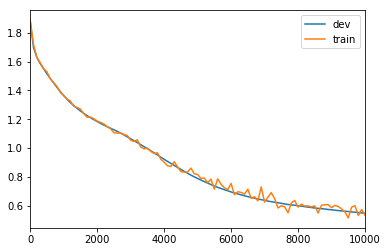

In [47]:
df = pd.DataFrame(dict(train=np.array(train_loss), dev=np.array(dev_loss)), index=iters).plot()

反復のたびにlossの値が少しずつ下がっていっているのがわかりますね。学習データと、開発データが同時に同じように下がっていますので、学習は成功したようです。

## 精度を計算する

それでは学習したモデルを使って実際に精度を計算してみましょう。

テストデータをモデルに与えます。

In [48]:
with configuration.using_config('train', False):
    y = model(test_X_scale)

各データに対して6次元の結果が帰ってきていますので、そのうち値が最大となった次元を求めます。

In [49]:
pred = np.argmax(y.data, axis=1)

In [50]:
from sklearn.metrics import classification_report

RecallとPrecisionを見てみましょう。

In [51]:
print(classification_report(test_Y, pred))

             precision    recall  f1-score   support

          0       0.55      0.99      0.71       496
          1       0.62      0.04      0.08       491
          2       0.53      0.98      0.69       532
          3       0.93      0.93      0.93       471
          4       0.99      0.99      0.99       537
          5       0.69      0.03      0.05       420

avg / total       0.72      0.69      0.59      2947



かなり偏りがありますね。実際にどう間違えたのかconfusion matrixで見てみましょう。

In [52]:
pd.crosstab(test_Y, pred)

col_0,0,1,2,3,4,5
row_0,,,,,,
0,493,0,0,2,0,1
1,0,20,467,1,3,0
2,0,9,523,0,0,0
3,27,0,0,440,0,4
4,0,3,0,0,534,0
5,380,0,0,29,0,11


# 演習

レイヤーの数やアクティベーション関数などを変えてみて、性能がどのように変わるか検証してみましょう。

## 参考資料

https://docs.chainer.org/en/stable/tutorial/basic.html